#Проект: Определение жанра музыкального альбома

Проект состоит из следующих пунктов:
- ознакомление с данными;
- создание baseline модели;
- создание нейронной сети;
- Выводы.

Загрузим необходимые библиотеки

In [4]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights, resnet34
import torch
from torch.autograd import Variable
import tqdm
from tqdm import tqdm
import faiss
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score
from fastai.vision.all import *

In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [6]:
path = 'drive/MyDrive/cover/'

## Ознакомление с данными

Посмотрим на данные.

In [13]:
folder = os.listdir('drive/MyDrive/cover')
print('У нас есть', len(folder),'папок с файлами:', *folder)

У нас есть 10 папок с файлами: anime black metal classical country disco edm jazz pop rap reggae


Посмотрим, что внутри папок.

В папке anime находится 1189  изображений
В папке black metal находится 450  изображений
В папке classical находится 955  изображений
В папке country находится 1486  изображений
В папке disco находится 475  изображений
В папке edm находится 719  изображений
В папке jazz находится 821  изображений
В папке pop находится 803  изображений
В папке rap находится 328  изображений
В папке reggae находится 581  изображений


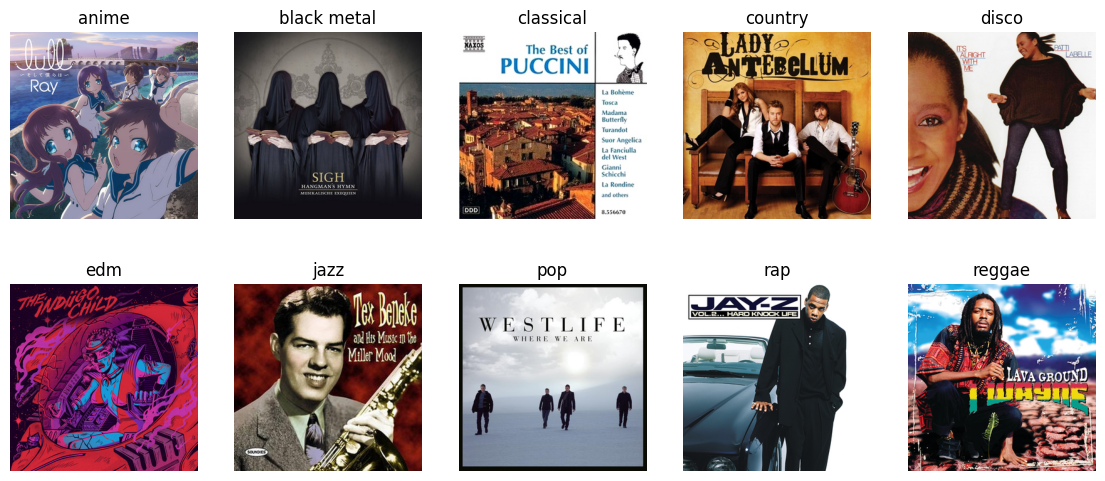

In [14]:
fig = plt.figure(figsize=(14,6))
for i in range(len(folder)):
    file = os.listdir(path+folder[i])
    print('В папке', folder[i], 'находится', len(file),' изображений')
    filename= '{}/{}'.format(folder[i],file[1])
    plt.subplot(2,5, i+1)
    plt.imshow(Image.open(path+filename))
    plt.title(folder[i])
    plt.axis('off')
plt.show()

Видны несбалансированные классы, что необходимо будет участь при построении модели.

## Создание baseline модели

Соберем датафрейм. Сделаем множествo датафреймов для экономии ОЗУ и вычислительных мощностей.

In [15]:
def df_new(title):
    name = os.listdir(path+title)
    df=pd.DataFrame(name, columns=['name'])
    df['genre']=title
    return df

In [16]:
anime_df = df_new('anime')
anime_df.shape

(1189, 2)

In [17]:
metal_df = df_new('black metal')
metal_df.shape

(450, 2)

In [18]:
classical_df = df_new('classical')
classical_df.shape

(955, 2)

In [19]:
country_df = df_new('country')
country_df.shape

(1486, 2)

In [20]:
disco_df = df_new('disco')
disco_df.shape

(475, 2)

In [21]:
edm_df = df_new('edm')
edm_df.shape

(719, 2)

In [22]:
jazz_df = df_new('jazz')
jazz_df.shape

(821, 2)

In [23]:
pop_df = df_new('pop')
pop_df.shape

(803, 2)

In [24]:
rap_df = df_new('rap')
rap_df.shape

(328, 2)

In [25]:
reggae_df = df_new('reggae')
reggae_df.shape

(581, 2)

Проведем векторизацию изображений

In [26]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

In [27]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [28]:
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
for param in resnet50.parameters():
    param.requires_grad_(False)
layers = list(resnet50.children())[:-1]
resnet50 = torch.nn.Sequential(*layers)
resnet50.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [29]:
tensor_anime = []
file = os.listdir(path+'anime')

In [30]:
def one_anime(i):
    filename= '{}/{}'.format(path+'anime',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = transform(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_anime.append([z])

In [31]:
for i in range(len(anime_df)):
    one_anime(i)
len(tensor_anime)

1189

In [32]:
tensor_metal = []
file = os.listdir(path+'black metal')

In [33]:
def one_metal(i):
    filename= '{}/{}'.format(path+'black metal',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = transform(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_metal.append([z])

In [34]:
for i in range (len(metal_df)):
    one_metal(i)
len(tensor_metal)

450

In [35]:
tensor_classical = []
file = os.listdir(path+'classical')

In [36]:
def one_classical(i):
    filename= '{}/{}'.format(path+'classical',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_classical.append([z])

In [37]:
for i in range (len(classical_df)):
    one_classical(i)
len(tensor_classical)

955

In [38]:
tensor_country = []
file = os.listdir(path+'country')

In [39]:
def one_country(i):
    filename= '{}/{}'.format(path+'country',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_country.append([z])

In [40]:
for i in range (len(country_df)):
    one_country(i)
len(tensor_country)

1486

In [41]:
tensor_jazz = []
file = os.listdir(path+'jazz')

In [42]:
def one_jazz(i):
    filename= '{}/{}'.format(path+'jazz',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_jazz.append([z])

In [43]:
for i in range (len(jazz_df)):
    one_jazz(i)
len(tensor_jazz)

821

In [44]:
tensor_pop = []
file = os.listdir(path+'pop')

In [45]:
def one_pop(i):
    filename= '{}/{}'.format(path+'pop',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_pop.append([z])

In [46]:
for i in range (len(pop_df)):
    one_pop(i)
len(tensor_pop)

803

In [47]:
tensor_reggae = []
file = os.listdir(path+'reggae')

In [48]:
def one_reggae(i):
    filename= '{}/{}'.format(path+'reggae',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_reggae.append([z])

In [49]:
for i in range (len(reggae_df)):
    one_reggae(i)
len(tensor_reggae)

581

In [50]:
tensor_disco = []
file = os.listdir(path+'disco')

In [51]:
def one_disco(i):
    filename= '{}/{}'.format(path+'disco',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_disco.append([z])

In [52]:
for i in range (len(disco_df)):
    one_disco(i)
len(tensor_disco)

475

In [53]:
tensor_edm = []
file = os.listdir(path+'edm')

In [54]:
def one_edm(i):
    filename= '{}/{}'.format(path+'edm',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_edm.append([z])

In [55]:
for i in range (len(edm_df)):
    one_edm(i)
len(tensor_edm)

719

In [56]:
tensor_rap = []
file = os.listdir(path+'rap')

In [57]:
def one_rap(i):
    filename= '{}/{}'.format(path+'rap',file[i])
    img = Image.open(filename).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(2048)
    tensor_rap.append([z])

In [58]:
for i in range (len(rap_df)):
    one_rap(i)
len(tensor_rap)

328

In [59]:
df = pd.DataFrame(data=tensor_anime, columns = ['tensor'])
anime_df = pd.concat([anime_df,df],axis=1)
df = pd.DataFrame(data=tensor_metal, columns = ['tensor'])
metal_df = pd.concat([metal_df,df],axis=1)
df = pd.DataFrame(data=tensor_classical, columns = ['tensor'])
classical_df = pd.concat([classical_df,df],axis=1)
df = pd.DataFrame(data=tensor_country, columns = ['tensor'])
country_df = pd.concat([country_df,df],axis=1)
df = pd.DataFrame(data=tensor_disco, columns = ['tensor'])
disco_df = pd.concat([disco_df,df],axis=1)
df = pd.DataFrame(data=tensor_edm, columns = ['tensor'])
edm_df = pd.concat([edm_df,df],axis=1)
df = pd.DataFrame(data=tensor_jazz, columns = ['tensor'])
jazz_df = pd.concat([jazz_df,df],axis=1)
df = pd.DataFrame(data=tensor_pop, columns = ['tensor'])
pop_df = pd.concat([pop_df,df],axis=1)
df = pd.DataFrame(data=tensor_reggae, columns = ['tensor'])
reggae_df = pd.concat([reggae_df,df],axis=1)
df = pd.DataFrame(data=tensor_rap, columns = ['tensor'])
rap_df = pd.concat([rap_df,df],axis=1)

Соберем итоговый датафрейм

In [60]:
df_total = pd.concat([anime_df, metal_df,classical_df, country_df, disco_df,
                      edm_df, jazz_df, pop_df, reggae_df,
                      rap_df], ignore_index=True, axis =0)
df_total.shape

(7807, 3)

Разделим все файлы на тренировочную и тестовую выборку.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    df_total.drop('genre', axis=1),
    df_total['genre'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df_total['genre'])

In [101]:
X_train = X_train.reset_index(drop=True)
X_train.shape

(6245, 2)

In [103]:
X_train_array = np.stack(X_train['tensor'])
X_train_array.shape

(6245, 2048)

In [104]:
y_train = y_train.reset_index(drop=True)
y_train.shape

(6245,)

In [105]:
X_test = X_test.reset_index(drop = True)
X_test.shape

(1562, 2)

In [106]:
X_test_array = np.stack(X_test['tensor'])
X_test_array.shape

(1562, 2048)

In [107]:
y_test = y_test.reset_index(drop=True)
y_test.shape

(1562,)

Рассчитаем схожесть векторов

In [108]:
index = faiss.IndexFlatL2(2048)
index.add(X_train_array)
print(index.ntotal)

6245


In [109]:
_, I = index.search(X_test_array, 5)

In [110]:
fiass_df = pd.DataFrame(I)
fiass_df[0] =fiass_df[0].apply(lambda x:y_train[x])
fiass_df[1] =fiass_df[1].apply(lambda x:y_train[x])
fiass_df[2] =fiass_df[2].apply(lambda x:y_train[x])
fiass_df[3] =fiass_df[3].apply(lambda x:y_train[x])
fiass_df[4] =fiass_df[4].apply(lambda x:y_train[x])
fiass_df['pred'] = fiass_df.mode(axis =1)[0]
fiass_df = fiass_df.join(y_test.to_frame())
fiass_df.head(10)

0            1            2            3            4  \
0        disco        disco          edm      country      country   
1      country      country      country        disco    classical   
2          pop        disco          pop      country          pop   
3    classical    classical    classical         jazz    classical   
4        anime          pop          edm      country          pop   
5        anime      country        disco        disco      country   
6        anime        anime        anime        anime        anime   
7          edm        disco          rap          edm          pop   
8  black metal  black metal  black metal  black metal  black metal   
9      country      country      country      country      country   

          pred        genre  
0      country    classical  
1      country        disco  
2          pop      country  
3    classical         jazz  
4          pop        anime  
5      country        disco  
6        anime        anime  
7          edm        anime  
8  black metal  black metal  
9      country      country

In [111]:
print('Метрика accuracy для fiass:', accuracy_score(fiass_df['genre'], fiass_df['pred']))

Метрика accuracy для fiass: 0.5025608194622279


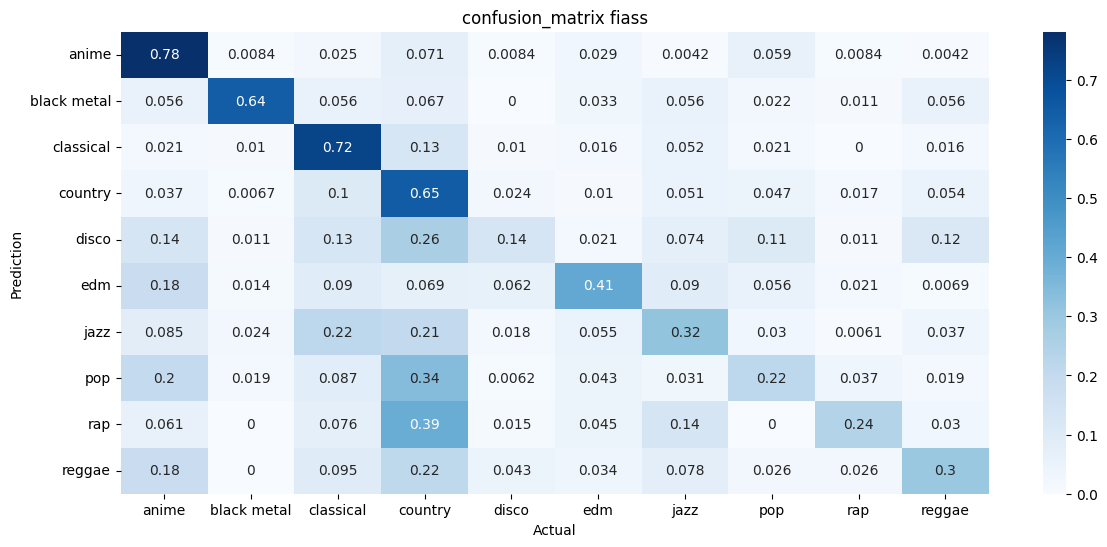

In [73]:
cm = confusion_matrix(fiass_df['genre'], fiass_df['pred'])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,6))
sns.heatmap(cmn, annot=True, cmap = 'Blues',
            xticklabels=sorted(fiass_df['genre'].unique()),
            yticklabels=sorted(fiass_df['genre'].unique()))
plt.title('confusion_matrix fiass')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

In [159]:
def test(a):
    print('Проверяемая картинка:')
    plt.imshow(Image.open(path+a))
    plt.show()
    img = Image.open('drive/MyDrive/cover/'+a).convert('RGB')
    img1 = preprocess(img)
    x = torch.unsqueeze(img1, dim=0)
    y = resnet50(x).detach().numpy()
    z = y.reshape(1,2048)
    D, I = index.search(z, 5)
    one_df = pd.DataFrame(I)
    fig = plt.figure(figsize=(14,6))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(Image.open(path+y_train.iloc[one_df[i][0]]+'/'+X_train.iloc[one_df[i][0]]['name']))
        plt.title(y_train.iloc[one_df[i][0]])
        plt.axis('off')
    one_df[0] =one_df[0].apply(lambda x:y_train[x])
    one_df[1] =one_df[1].apply(lambda x:y_train[x])
    one_df[2] =one_df[2].apply(lambda x:y_train[x])
    one_df[3] =one_df[3].apply(lambda x:y_train[x])
    one_df[4] =one_df[4].apply(lambda x:y_train[x])
    print('Предсказанный жанр:',one_df.mode(axis=1)[0][0])
    print('Ближайшие соседи:')

Проверяемая картинка:


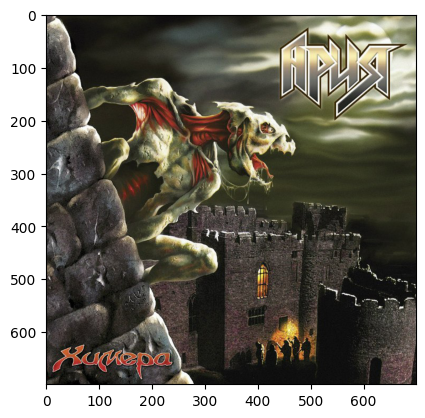

Предсказанный жанр: anime
Ближайшие соседи:


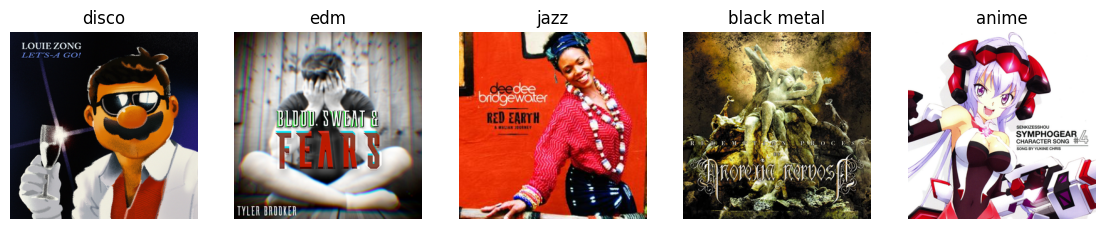

In [160]:
test('Aria-Chimera.png')

Модель определина правильно только одного соседа. Результат неудовлетворительный.  

Проверяемая картинка:


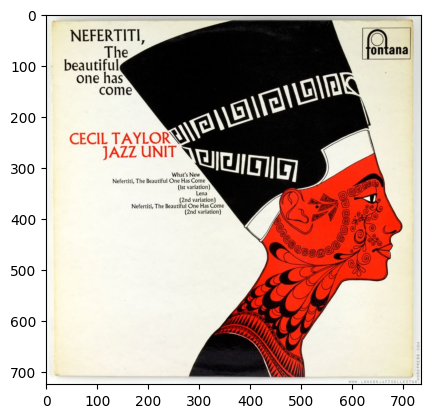

Предсказанный жанр: classical
Ближайшие соседи:


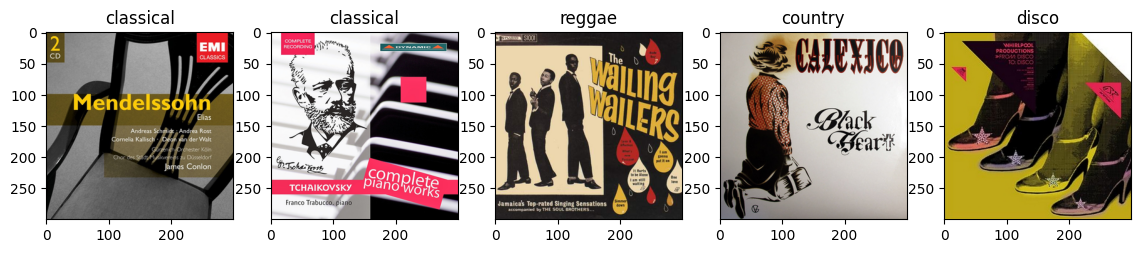

In [158]:
test('test_2.png')

Модель неправиьно определила жанр. Правильного жанра в ближайших соседях не обнаружено.

Проверяемая картинка:


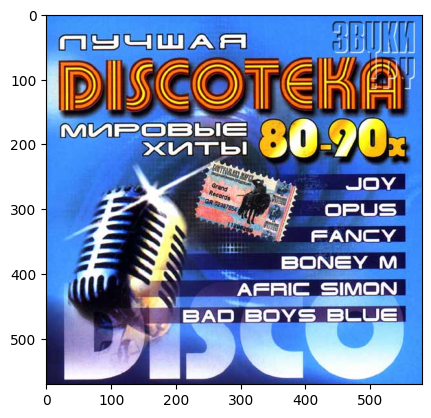

Предсказанный жанр: edm
Ближайшие соседи:


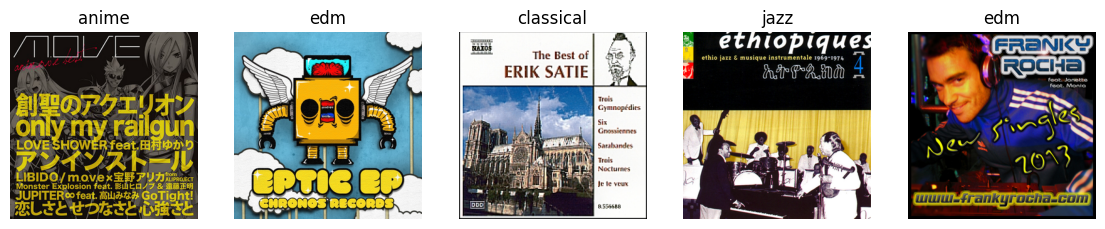

In [162]:
test('20467.png')

Модель неправильно определила жанр. Правильного соседа не обнаружено.

<u>Вывод по baseline модели: </u> Исходя из того, что в выборке 10 жанров, accuracy 0.5 неплохой результат для модели без обучения. Модель неплохо предсказывает аниме и классическую музыку, на остальных жанрах матрика близка к 0.5 либо существенно ниже. Диско-музыку модель предсказывает близко к значениям рандома. Из трех тестовых картинок правильно жанр не был определен ни на одной.

# Обучение модели с помощью fastai

Загрузим данные

In [7]:
dls = ImageDataLoaders.from_folder (path, train='train', valid='valid',
                               valid_pct=0.3, bs=64, seed=None, vocab=None,
                               item_tfms=None, batch_tfms=aug_transforms(max_rotate=20, max_warp=0.4),
                               device=None)

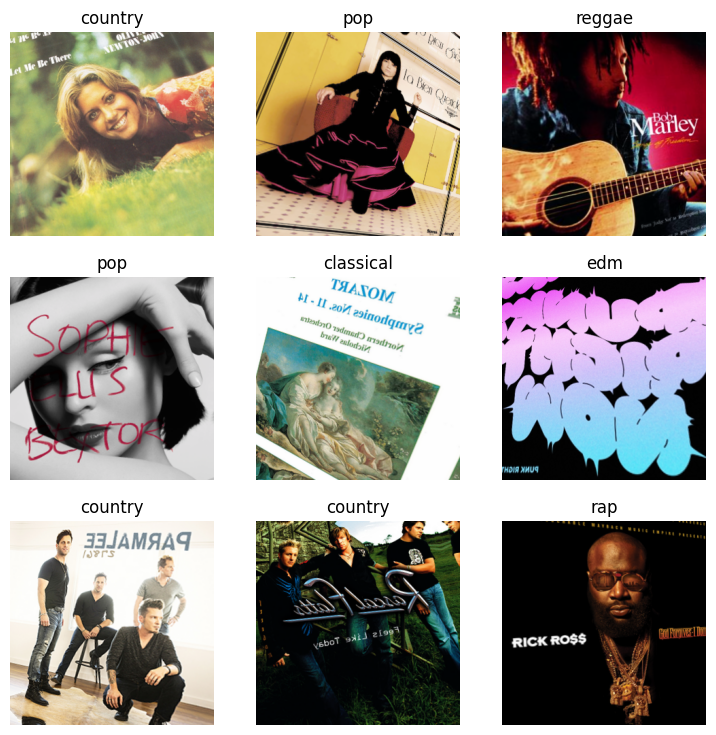

In [8]:
dls.show_batch(max_n=9)

In [9]:
import warnings
warnings.filterwarnings('ignore')

Обучим модель на 8 эпохах

In [10]:
learn = vision_learner(dls, resnet50, metrics=[accuracy, Precision(average='weighted'),
                                Recall(average='weighted'), F1Score(average='weighted')])
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.4MB/s]


Модель достигла своего максимума на 4 эпохе. После этого видно, что несмотря на рост метрик, модель начала переобучаться, на что показывает рост ошибки valid_loss. Метрика accuracy совпадает с метрикой recall, при этом все метики одинаково растут/падают. Это указывает на сбалансированность модели при определении жанра. Дальнейшее обучение модели приведет к улучшению предсказаний одной части жанров за счет ухудшения предсказаний другой части жанров. Модель тем самым будет подсраиваться под одни, многочасленные жанры, игнорируя иные.       

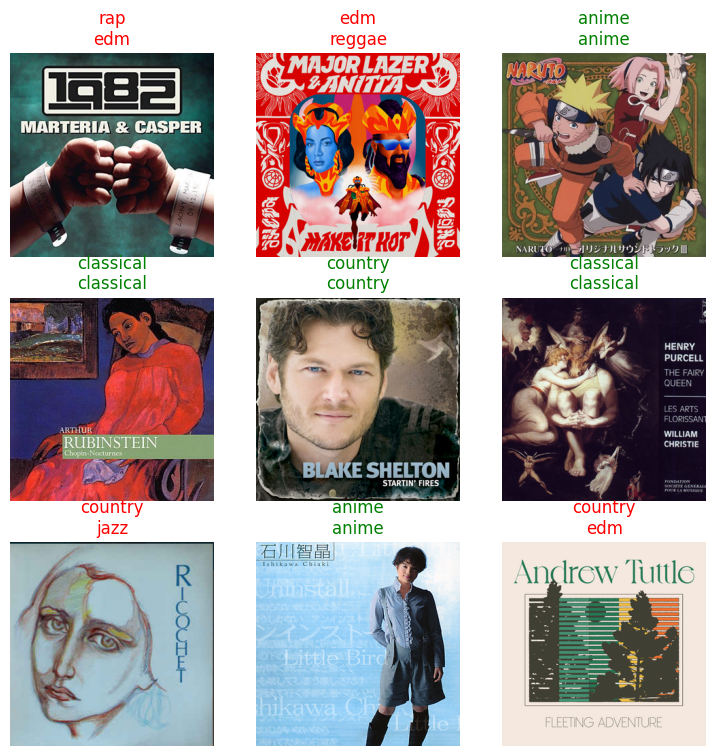

In [11]:
learn.show_results()

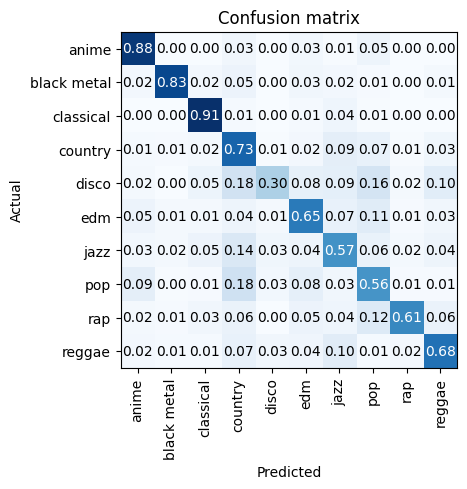

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

Медель хорошо предсказывает anime, bleak metal и классическую музыку. В тоже время country, самая многочисленная выборка, предсказана средне. Плохие показатели по правильным ответам у диско музыки. Возможно, влияет как размер выборки, так и цветовое отличие самих постеров. Bleaсk mеtal, насмотря на небольшую выборку, имеет темную и резкую палитру, что сильно отличается от иных направлений, что и дает 0.83 процента правильных ответов. Показатели по всем жанрам лучше, что у fiass модели без обучения.

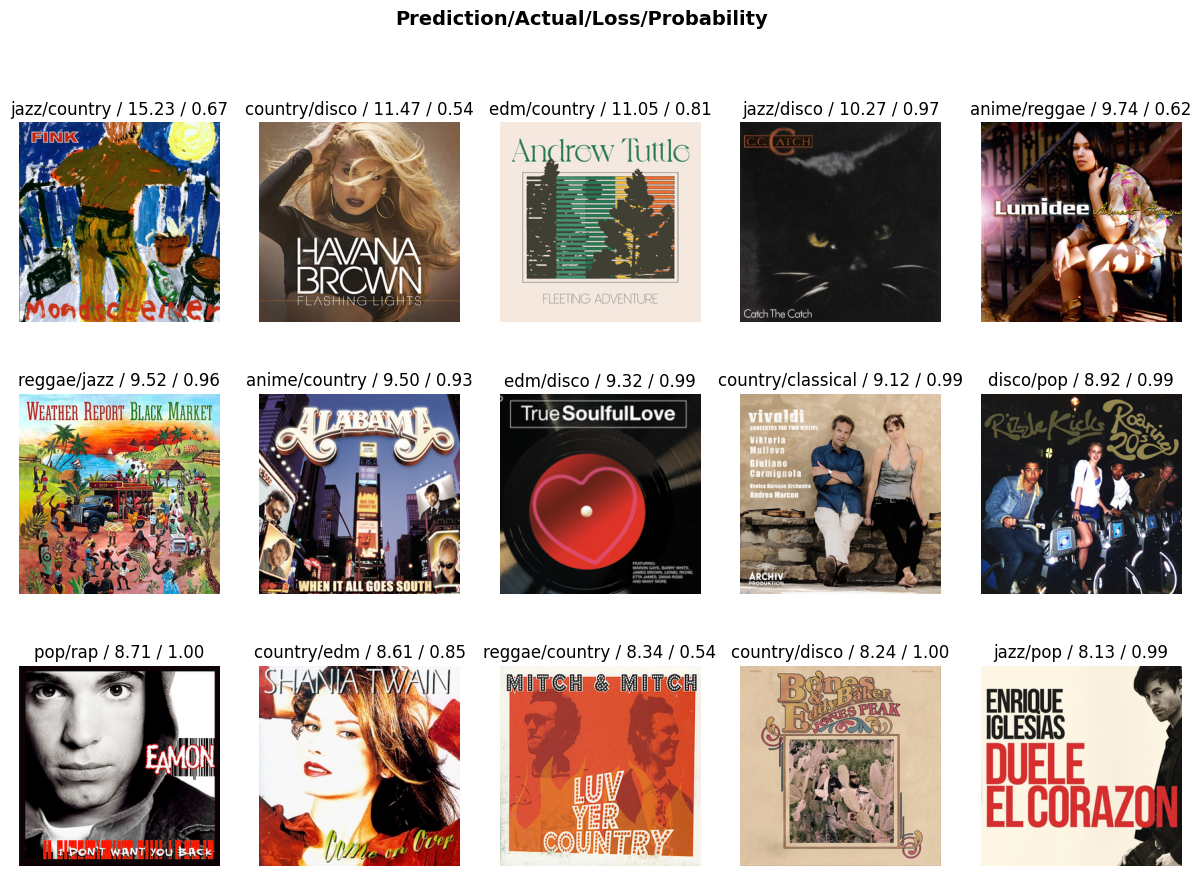

In [12]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(15, figsize=(15,10))

Ожидаемо, большие ошибки при определении жанра disco. Также плохие показатели у конкретных обложек у country.

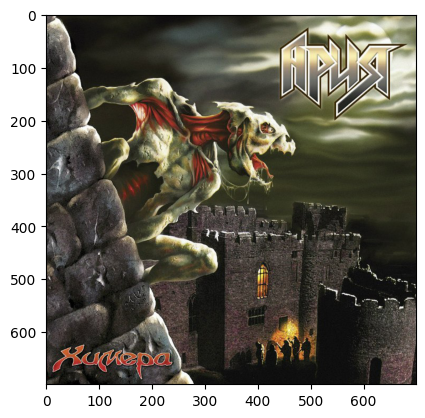

Предсказанный жанр:  black metal


In [29]:
plt.imshow(Image.open(path+'Aria-Chimera.png'))
plt.show()
a = learn.predict(path+'Aria-Chimera.png')
print('Предсказанный жанр: ',a[0])

Жанр определен правильно.

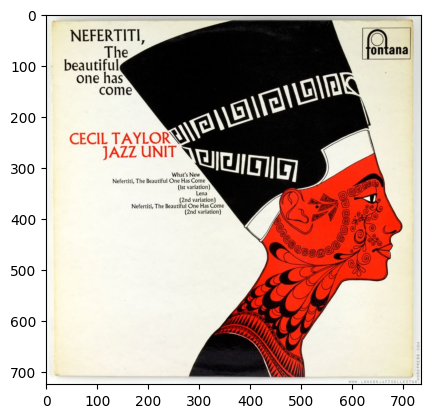

Предсказанный жанр:  jazz


In [28]:
plt.imshow(Image.open(path+'test_2.png'))
plt.show()
a = learn.predict(path+'test_2.png')
print('Предсказанный жанр: ',a[0])

Жанр определен оправильно.

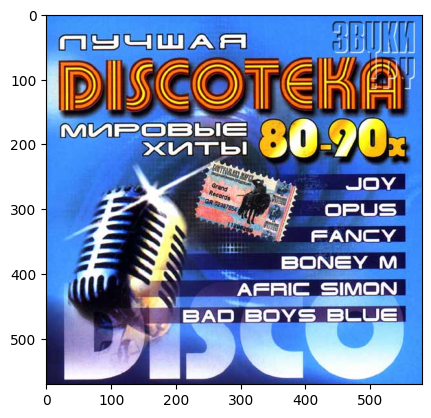

Предсказанный жанр:  disco


In [31]:
plt.imshow(Image.open(path+'20467.png'))
plt.show()
a = learn.predict(path+'20467.png')
print('Предсказанный жанр: ',a[0])

Жанр определен правильно.

# Вывод:

В данном проекте была создана модель, классифицирующая обложки музыкальных дисков по жанрам.

В проекте использовалось 7800 обложек, заранее разобранных по жанрам, создана модель fiass без обучения, а также нейронная сеть с использованием библотеки fastai. В результате обучения возникли следующие показатели:
- Метрика accuracy на fiass модели - 0.50, нейронная сеть показала метрику - 0.70.
- Процент правильных ответов на всех жанрах лучше у нейронной сети.
- Хорошо определяемые жанры у моделей примерно одинаковы. Плохо определяется disco, хорошо - аниме, металл и классическая музыка.
- Fiass-модель не смогла определить жанр трех рандомных картинок, нейронная сеть с этим справилась.

Созданная модель может быть улучшена увеличением размера тренировочной выборки, добавлением новых жанров для классификации.